# *Expectation Maximization* para misturas gaussianas
---

Podemos modelar variáveis correlacionadas com **variáveis latentes**, a fim de agrupar observações com características similares. Uma exemplo simples dessa abordagem é a clusterização, mais precisamente o algoritmo de *K-médias*. Essa abordagem é bastante útil pois, uma vez que os dados pertencem a um mesmo grupo (ou seja, possuem um mesmo valor para sua variável latente), podemos modelar uma distribuição para eles. Essa abordagem da origem ao que é conhecido como **modelo de mistura**. Como utilizaremos uma distribuição normal, temos um **modelo de mistura gaussiana**.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

Como o objetivo é identificar as variáveis latentes $z$, vamos utilizar um gerador de dados sintéticos de clusterização

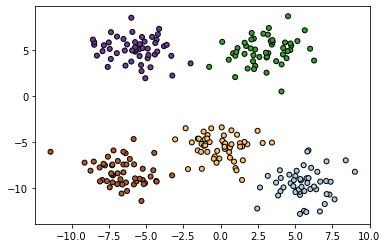

In [2]:
n_clusters = 5

X, Y = X, y = make_blobs(n_samples=[50 for _ in range(n_clusters)], n_features=2,
                  random_state=10, cluster_std=1.5, shuffle=True)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

Para calcular a probabilidade de um valor $x$ pertencer aos dados, podemos utilizar a seguinte fórmula:

$$p(x | \theta) = \sum^K_{k=1} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k) $$

onde:
- $\theta$ são os parâmetros das distribuições para cada valor k da variável latente (i.e., as distribuições dos grupos)
- $\pi_k$ é o "peso" da variavel latente ter valor k

Em geral, podemos computar a verossimilhança dos dados observados com:

$$ p(\textbf{X} | \theta)  = \prod^{N}_{i=u} \sum_{z_k} p(x_i | z_k, \theta) p(z_k | \theta) $$

Consequentemente, sua log-verossimilhança dá-se por:

$$ \mathcal{L}(\theta) = \sum^N_{i=1}log \left[ \sum_{z_k}p(x_i,z_k|\theta) \right] $$
 

Entretanto, como as variáveis latentes não são observadas, não podemos usar abordagens de maior verossimilhança (ML) ou máximo à posteriori (MAP). Todavia, podemos utilizar o método de ***expectation maximization*** (EM), onde, a partir da esperança de $\mathcal{L}_c (\theta)$ (etapa E) e otímizá-lo em função de $\theta$ (etapa M)

A etapa E consiste em, primeiramente, computar um valor que denote a *responsabilidade* de uma variável latente de valor $k$ para um dado $x_i$, ou seja, um valor que seja proporcional à $p(z_i = k | x_i, \theta)$ :

$$ r_{ik} \triangleq p(z = k | x_i, \theta) = \frac{\pi_k \mathcal{N}(x_i|\mu_k,\Sigma_k)}{\sum^K_{k'=1} \pi_{k'} \mathcal{N}(x_i | \mu_{k'}, \Sigma_{k'})}$$

A partir dos valores $r_{ik}$, fazemos a atualização de $\theta$ para cada $k$ (etapa M). Os parâmetros das distribuições são atualizados com as seguintes fórmulas:

$$ \pi^{new}_k = \frac{\alpha_k - 1 + \sum_i r_{ik}}{N - K + \sum_k \alpha_k} $$,
onde $\alpha_k$ é o parâmetro $\alpha$ da distribuição à priori de \$pi$, $N$ é o número total de amostras e $K$ o de valores para a variável latente; 


$$\mu_k^{new} = \frac{\mathcal{k}_0 \textbf{m}_0 +\overline{x}_k \sum_i r_{ik}}{\mathcal{k}_0 + \sum_i r_{ik}}, \; \overline{x}_k \triangleq \frac{\sum_i r_{ik} x_i}{\sum_i r_{ik}} $$,

onde $m_0$ é o valor inicial da média e $\mathcal{k}_0$ é um hiperparâmetro (normalmente próximo e 0);


$$ \Sigma_k^{new} = \frac{\textbf{S}_0 + \sum_i (r_{ik} (x_i - \overline{x}_k)(x_i - \overline{x}_k)^T) + \frac{\mathcal{k}_0 \sum_i r_{ik}}{\mathcal{k}_0 + \sum_i r_{ik}}(\overline{x}_k - \textbf{m}_0)(\overline{x}_k - \textbf{m}_0)^T}{\mathcal{v_0} + D + 2 + \sum_i r_{ik}} $$,

onde $\textbf{S}_0$ é a matrix de covariância inicial, $D$ é o número de atributos de $\textbf{X}$ e $\mathcal{v}_0$ é um hiperparâmetro.

Uma vez que a etapa M é executada, podemos então recomputar as *responsabilidades* (etapa E) e otimizar novamente a função (etapa M). Aplicamos esses passos até que um certo critério de parada seja satisfeito

In [3]:
def r_k(x, mean, cov, pi, k):
    
    a = pi[k] * multivariate_normal(mean[k], cov[k]).pdf(x)
    b = np.sum([pi[p] * multivariate_normal(mean[p], cov[p]).pdf(x) for p in range(pi.shape[0])])
    
    if b == 0:
        pass
    
    return a/b

def log_likelihood(X, mean_prev, cov_prev, pi_prev, mean, cov, pi):
    l = 0
    
    for k in range(pi.shape[0]):
        responsabilities = r_k(X, mean_prev, cov_prev, pi_prev, k)
        l += responsabilities.dot(np.log(pi[k] * multivariate_normal(mean[k], cov[k]).pdf(X)))
    
    return l

def EM(X, K, mean_0, cov_0, pi_0, alphas, k_0, v_0, iter=10, debug=False):
    N, D = X.shape
    mean_prev = mean_0.copy()
    cov_prev = cov_0.copy()
    pi_prev = pi_0.copy()
    
    mean = mean_0.copy()
    cov = cov_0.copy()
    pi = pi_0.copy()
    
    log_likelihoods = []
    
    for i in range(iter):
        if debug:
            print(f"Iteração {i} #############")
        for k in range(K): # para cada valor latente
#             responsabilities = np.array([r_k(x_i, mean_prev, cov_prev, pi_prev, k) for x_i in X])
            responsabilities = r_k(X, mean_prev, cov_prev, pi_prev, k)
            sum_res = np.sum(responsabilities, axis=0) 
            # valor atualizado da probabilidade categórica de k
            pi[k] = (alphas[k] - 1 + sum_res) / (N - K + np.sum(alphas))
            
            # x_i ponderado pela responsabilidade
            x_k = responsabilities.dot(X) / sum_res
            mean[k,:] = (k_0 * mean_0[k,:] + x_k * sum_res) / (k_0 + sum_res)

            distances = responsabilities.dot(X - x_k)
            cov_k = (cov_0[k,:,:] + distances.T.dot(distances) + (k_0*sum_res / (k_0 + sum_res)) * np.outer(x_k - mean_0[k,:], x_k - mean_0[k,:]))
            cov_k = cov_k / (v_0 + D + 2 + sum_res)
            cov[k,:,:] =  cov_k
            
            if debug:
                print(f"Variavel latente {k}:")
                print(f"média: {mean[k]}")
                print(f"covariância:\n{cov[k]}\n\n")
                print(f"pi: {pi[k]}")
                print("-------------------------\n")
                
        log_likelihoods.append(log_likelihood(X, mean_prev, cov_prev, pi_prev, mean, cov, pi))
        
        if debug:
            print(f"Log verossimilhança: {log_likelihoods[-1]}")
        
        mean_prev = mean.copy()
        cov_prev = cov.copy()
        pi_prev = pi.copy()

    return mean, cov, pi, log_likelihoods

Para inicializar os hiperparâmetros de média, podemos utilizar o *K-médias* (já implementado), onde os clusters encontrados representarão $m_o$. Para as covariâncias, vamos utilizar as variâncias dos atributos do dataset.

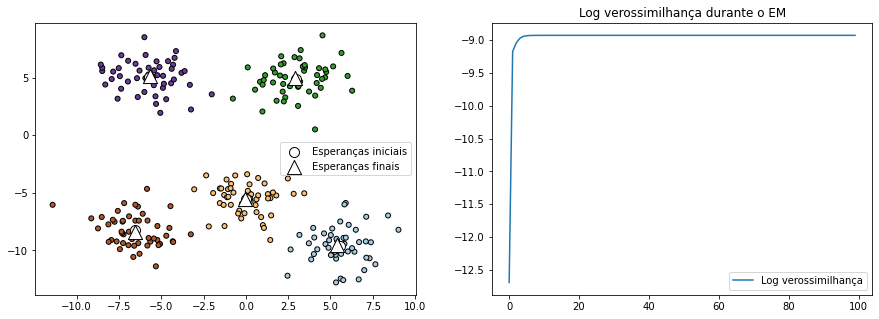

In [4]:
from sklearn.cluster import KMeans
def generate_initial_values(X, K, dim):
    mean_0 = KMeans(n_clusters=n_clusters, random_state=42).fit(X).cluster_centers_
    cov_0 = np.array([np.diag(np.var(X,axis=0)) for _ in range(K)])
    
    return mean_0, cov_0

K = n_clusters
mean_0, cov_0 = generate_initial_values(X, K=K, dim=X.shape[1])
pi_0 = np.array([1/K for _ in range(K)])
alphas = np.array([2 for _ in range(K)])


mean, cov, pi, l = EM(X, K, mean_0, cov_0, pi_0, alphas, 0, 4, iter=100, debug=False)

# print("\n##########################\n")
# print("Resultados finais: ")
# for k in range(K):
#     print(f"Variavel latente {k}:")
#     print(f"média: {mean[k]}")
#     print(f"covariância:\n{cov[k]}\n")
#     print(f"pi: {pi[k]}")
#     print("-------------------------\n")
    
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
plt.scatter(mean_0[:,0], mean_0[:,1], marker="o", c="w", s=100, edgecolors='k', label="Esperanças iniciais")
plt.scatter(mean[:,0], mean[:,1], marker="^", c="w", s=200, edgecolors='k', label="Esperanças finais")
plt.legend()
    
plt.subplot(1,2,2)
plt.plot(l, label="Log verossimilhança")
plt.legend()
_ = plt.title("Log verossimilhança durante o EM")

(5, 250)
(5, 40000)


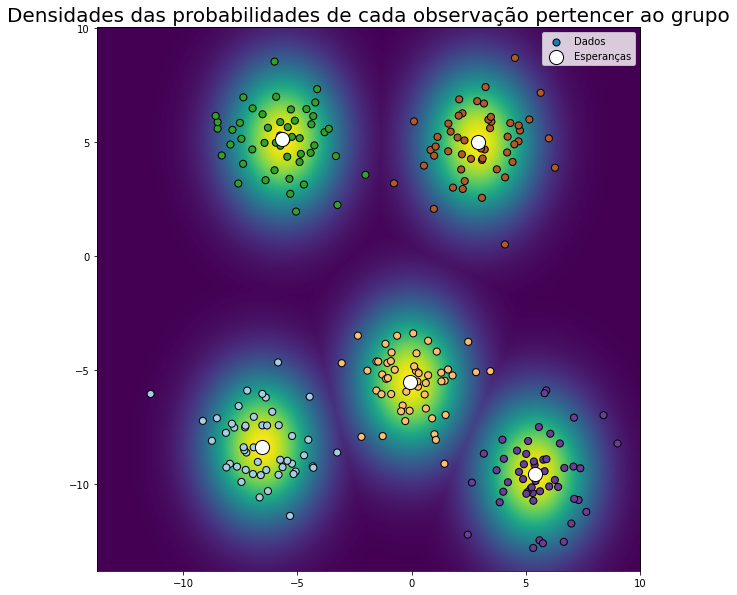

In [5]:
def get_prob(X, mean, cov, pi, with_k=False, responsabilities = None):
    K = mean.shape[0]
    if responsabilities is None:
        responsabilities = np.array([r_k(X, mean, cov, pi, k) for k in range(K)])
    ks = np.argmax(responsabilities, axis=0)
    print(responsabilities.shape)
    probs = np.array([multivariate_normal(mean[k], cov[k]).pdf(x) for x,k in zip(X, ks)])
    
    if with_k:
        return probs, ks
    else:
        return probs

z = get_prob(X, mean, cov, pi, with_k=True)[1]
    
resolution = 200
margin = 1
x = y = np.linspace(X.min()-margin,X.max()+margin,resolution)
grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)

densities = get_prob(grid, mean, cov, pi).reshape(resolution, resolution)

plt.figure(figsize=(10,10))
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades de cada observação pertencer ao grupo", fontsize=20)
plt.legend()

### Comparando com a implementação do [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)

Vamos comparar as distribuições encontradas nesta implementação com as encontradas pelo módulo do sklearn

In [6]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=K, random_state=42).fit(X)

(5, 40000)


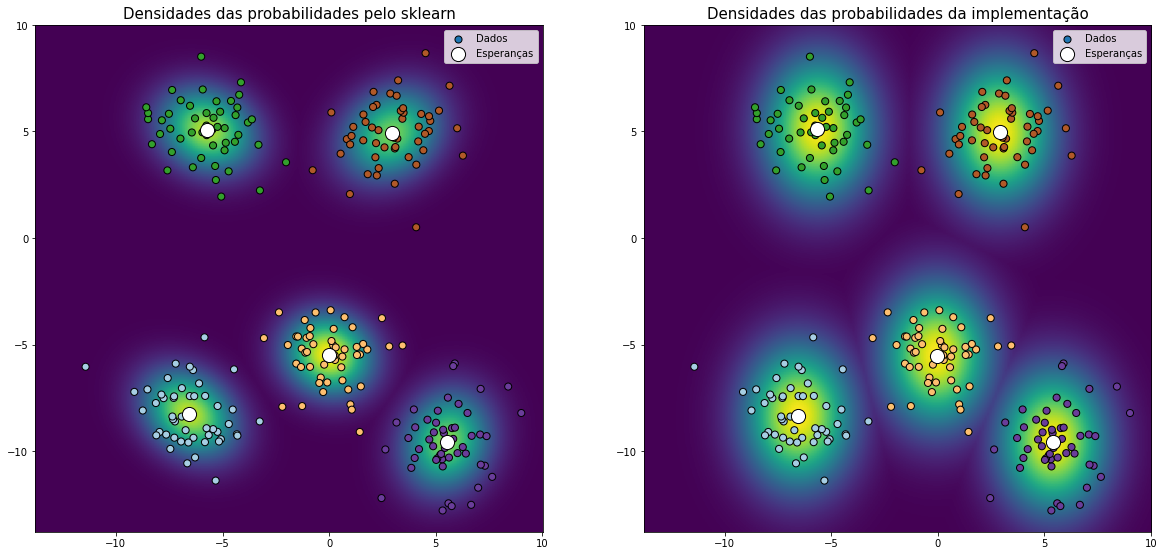

In [7]:
densities_sklearn = get_prob(grid, gm.means_, gm.covariances_, gm.weights_, responsabilities=gm.predict_proba(grid).T).reshape(resolution, resolution)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(densities_sklearn, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=gm.predict(X),
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(gm.means_[:,0], gm.means_[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades pelo sklearn", fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades da implementação", fontsize=15)
_ = plt.legend()